# Task 2
This serves as a template which will guide you through the implementation of this task. It is advised to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps.
This is the jupyter notebook version of the template. For the python file version, please refer to the file `template_solution.py`.

First, we import necessary libraries:

In [ ]:
# data handling
import numpy as np
import pandas as pd
from scipy import stats
# Add any other imports you need here

# plotting
import seaborn as sns
from matplotlib import pyplot as plt

# preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

# training
from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, Matern, RationalQuadratic
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform


# set exploration options for print
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# set display to be interactive for pipelines
import sklearn
sklearn.set_config(display="diagram")

# Data Loading
TODO: Perform data preprocessing, imputation and extract X_test, y_train and X_test
(and potentially change initialization of variables to accomodate how you deal with non-numeric data)

In [ ]:
"""
This loads the testing and test data, preprocesses it, removes the NaN
values and interpolates the missing data using imputation

Parameters
----------
Compute
----------
X_test: matrix of floats, testing input with features
y_train: array of floats, training output with labels
X_test: matrix of floats: dim = (100, ?), test input with features
"""
# Load training data
train_df = pd.read_csv("train.csv")
    
print("testing data:")
print("Shape:", train_df.shape)
print(train_df.head(2))
print('\n')
    
# Load test data
test_df = pd.read_csv("test.csv")

print("Test data:")
print(test_df.shape)
print(test_df.head(2))

testing data:
Shape: (900, 11)
   season  price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
0  spring        NaN   9.644028  -1.686248  -1.748076  -3.666005        NaN   
1  summer        NaN   7.246061  -2.132377  -2.054363  -3.295697  -4.104759   

   price_UK  price_ITA  price_POL  price_SVK  
0 -1.822720  -3.931031        NaN  -3.238197  
1 -1.826021        NaN        NaN  -3.212894  


Test data:
(100, 10)
   season  price_AUS  price_CZE  price_GER  price_ESP  price_FRA  price_UK  \
0  spring        NaN   0.472985   0.707957        NaN  -1.136441 -0.596703   
1  summer  -1.184837   0.358019        NaN  -3.199028  -1.069695       NaN   

   price_ITA  price_POL  price_SVK  
0        NaN   3.298693   1.921886  
1  -1.420091   3.238307        NaN  


# Data Exploration
Check columns and their NA counts

In [ ]:
print("training data numeric counts: \n")
print(train_df.describe().iloc[0, :])
print("\n training data character count: ")
print(train_df.season.value_counts())
print("\n NA counts:")
print(train_df.isna().sum(axis = 0).T)
# we see that every third number is NA in numerical features :(

training data numeric counts: 

price_AUS    638.0
price_CHF    631.0
price_CZE    632.0
price_GER    631.0
price_ESP    631.0
price_FRA    636.0
price_UK     613.0
price_ITA    634.0
price_POL    635.0
price_SVK    619.0
Name: count, dtype: float64

 training data character count: 
spring    225
summer    225
autumn    225
winter    225
Name: season, dtype: int64

 NA counts:
season         0
price_AUS    262
price_CHF    269
price_CZE    268
price_GER    269
price_ESP    269
price_FRA    264
price_UK     287
price_ITA    266
price_POL    265
price_SVK    281
dtype: int64


In [ ]:
print("testing data numeric counts: \n")
print(test_df.describe().iloc[0, :])
print("\n testing data character count: ")
print(test_df.season.value_counts())
print("\n NA counts:")
print(test_df.isna().sum(axis = 0).T)
# we see that every third number is NA in numerical features :(
# test_df.info()

testing data numeric counts: 

price_AUS    67.0
price_CZE    75.0
price_GER    69.0
price_ESP    61.0
price_FRA    75.0
price_UK     76.0
price_ITA    70.0
price_POL    65.0
price_SVK    66.0
Name: count, dtype: float64

 testing data character count: 
spring    25
summer    25
autumn    25
winter    25
Name: season, dtype: int64

 NA counts:
season        0
price_AUS    33
price_CZE    25
price_GER    31
price_ESP    39
price_FRA    25
price_UK     24
price_ITA    30
price_POL    35
price_SVK    34
dtype: int64


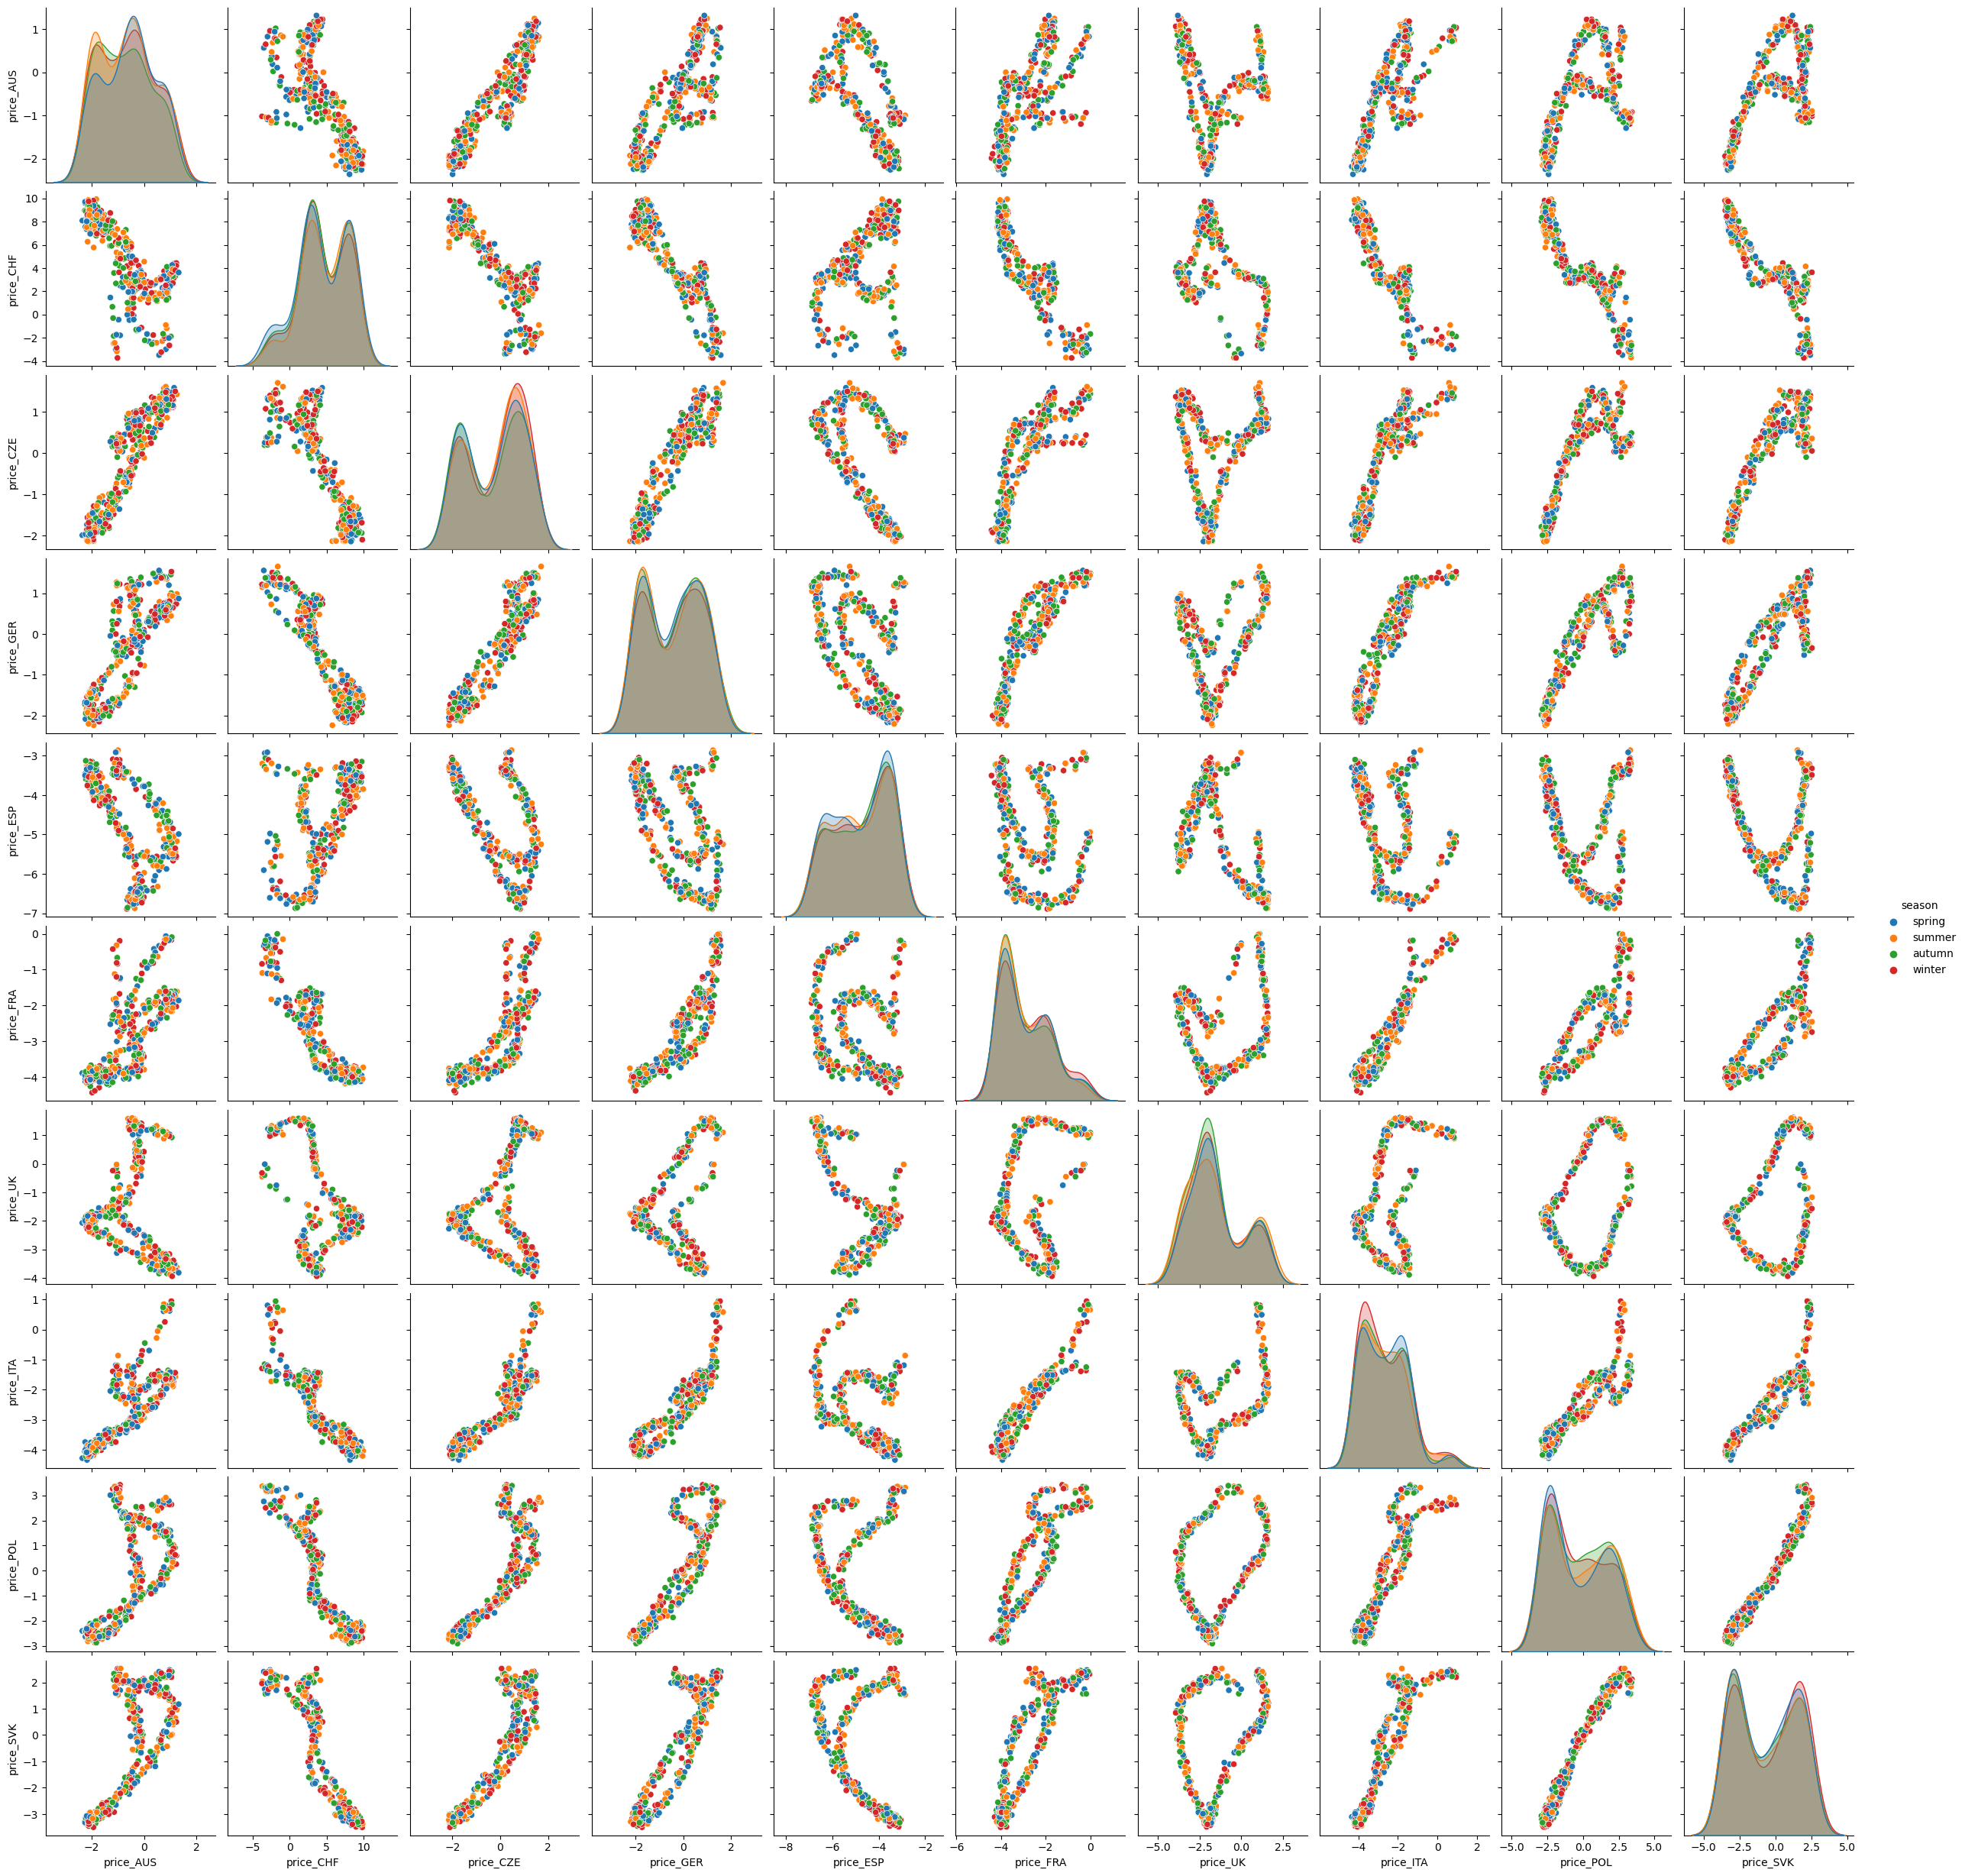

In [ ]:
# explore correlations and skewness of the data
sns.pairplot(train_df, hue = "season")

# !!! features seem to be strongly correlated and season also makes very little impact in my opinion 
# correlation patterns between features might become an issue here

C:\Users\paesc\AppData\Local\Temp\ipykernel_9716\1106678297.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, fmt = ".2f")


Text(0.5, 1.0, 'Correlation Heatmap')

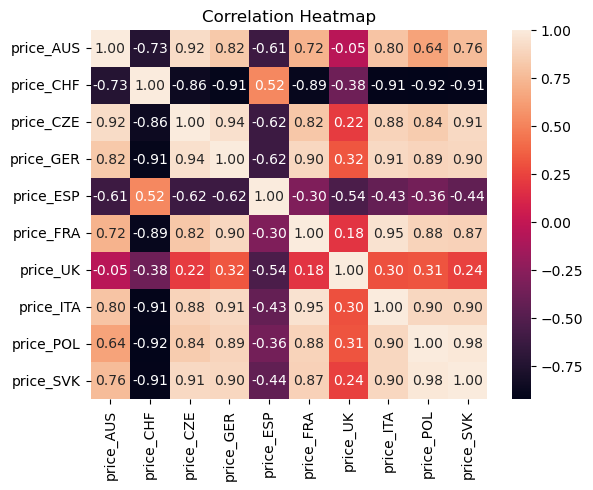

In [ ]:
sns.heatmap(train_df.corr(), annot=True, fmt = ".2f")
plt.title("Correlation Heatmap")
# price UK and ESP have relatively low correlation
# features ITA, POL, GER, SVK and CZE seem to be similar


## Preprocessing: NA handling in ground truth

In [ ]:
## For now: drop NAs in ground truth
def groud_truth_NA_handling(full_df, y_col = "price_CHF"):
    yNA_mask = full_df[y_col].isna()
    X = full_df[~yNA_mask].drop([y_col],axis=1)
    y = full_df[~yNA_mask].loc[:,y_col]
    return X, y

X_train, y_train = groud_truth_NA_handling(train_df)
X_test = test_df.copy()

# given assert from task
assert (X_train.shape[1] == X_test.shape[1]) and (X_train.shape[0] == y_train.shape[0]) and (X_test.shape[0] == 100), "Invalid data shape"

## Preprocessing exploration: Encoding, Imputing and Scaling
Try out preprocessing in manual style

In [ ]:
## Encode the character values and impute the numerical ones
X_train_num = X_train.select_dtypes(include=['number'])
X_train_cat = X_train.select_dtypes(include=['object', 'category'])

# Encode the season column
one_hot_encoder = OneHotEncoder()
X_train_cat_encoder = one_hot_encoder.fit(X_train_cat)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoder.transform(X_train_cat).toarray(), 
                                    columns=X_train_cat_encoder.get_feature_names_out(), 
                                    index=X_train_cat.index)


# Impute the features with KNNImputer or SimpleImputer
NN_explore = 5
imputer = KNNImputer(n_neighbors=NN_explore)

X_train_num_imputed = pd.DataFrame(imputer.fit_transform(X_train_num), 
                                   columns = X_train_num.columns, 
                                   index = X_train_num.index)

# Scale the numeric features from 0 to one rang
std_scaler = StandardScaler()
X_train_num_imputed_scaled = pd.DataFrame(std_scaler.fit_transform(X_train_num_imputed), 
                                   columns = X_train_num.columns, 
                                   index = X_train_num.index)


X_train_preprocessed = pd.concat([X_train_num_imputed_scaled, X_train_cat_encoded], axis = 1)



### Check data distribution after preprocessing

In [ ]:
# Next, we QC our preprocessing
# check
def quick_check(data):
    data_num = data.select_dtypes(include = ["number"]).copy()
    data_cat = data.select_dtypes(include = ["object", "category"]).copy()
    # numerics
    check1 = data_num.describe().T
    check2 = pd.DataFrame(data_num.isna().sum(), columns = ["NA.counts"])
    num_check = pd.concat([check1, check2], axis = 1)

    # return num if there are no cat columns
    if data_cat.shape[1] == 0: 
        return num_check
    
    else:
        # cathegories
        check3 = pd.DataFrame(data_cat.value_counts(), columns = ["Counts"])
        check4 = pd.DataFrame(pd.get_dummies(data_cat).isna().sum(axis = 0), columns=["NA.counts"])
        cat_check = pd.concat([check3, check4], axis = 1)
        return num_check, cat_check

# def cat_check(data):
# data_cat = X_train.select_dtypes(include = ["object", "category"]).copy()

# data = X_train_preprocessed.copy()


quick_check(X_train_preprocessed)

,count,mean,std,min,25%,50%,75%,max,NA.counts
price_AUS,631.0,5.630291e-17,1.000793,-1.598544,-1.001470,0.061547,0.655727,1.972190,0
price_CZE,631.0,3.378175e-17,1.000793,-1.518322,-1.075858,0.335618,0.841191,1.622409,0
price_GER,631.0,9.008466e-17,1.000793,-1.515466,-1.044995,0.149659,0.945023,1.884758,0
price_ESP,631.0,-4.391627e-16,1.000793,-1.922292,-0.786950,0.212020,0.945799,1.546625,0
price_FRA,631.0,1.689087e-17,1.000793,-1.117780,-0.867597,-0.368547,0.822576,2.803469,0
price_UK,631.0,0.000000e+00,1.000793,-1.529370,-0.656121,-0.193530,0.435815,2.090002,0
price_ITA,631.0,4.504233e-17,1.000793,-1.397787,-0.922261,-0.191708,0.819987,3.258022,0
price_POL,631.0,-2.252116e-17,1.000793,-1.248130,-0.987803,-0.178435,1.007862,1.979879,0
price_SVK,631.0,2.252116e-17,1.000793,-1.297157,-1.040143,-0.070034,1.013798,1.609073,0
season_autumn,631.0,2.551506e-01,0.436292,0.000000,0.000000,0.000000,1.000000,1.000000,0


In [ ]:
print("Stats: ")
print(X_train_preprocessed.describe())

Stats: 
          price_AUS     price_CZE     price_GER     price_ESP     price_FRA  \
count  6.310000e+02  6.310000e+02  6.310000e+02  6.310000e+02  6.310000e+02   
mean   5.630291e-17  3.378175e-17  9.008466e-17 -4.391627e-16  1.689087e-17   
std    1.000793e+00  1.000793e+00  1.000793e+00  1.000793e+00  1.000793e+00   
min   -1.598544e+00 -1.518322e+00 -1.515466e+00 -1.922292e+00 -1.117780e+00   
25%   -1.001470e+00 -1.075858e+00 -1.044995e+00 -7.869499e-01 -8.675966e-01   
50%    6.154715e-02  3.356176e-01  1.496593e-01  2.120202e-01 -3.685469e-01   
75%    6.557272e-01  8.411907e-01  9.450225e-01  9.457992e-01  8.225759e-01   
max    1.972190e+00  1.622409e+00  1.884758e+00  1.546625e+00  2.803469e+00   

         price_UK     price_ITA     price_POL     price_SVK  season_autumn  \
count  631.000000  6.310000e+02  6.310000e+02  6.310000e+02     631.000000   
mean     0.000000  4.504233e-17 -2.252116e-17  2.252116e-17       0.255151   
std      1.000793  1.000793e+00  1.000793e+00 

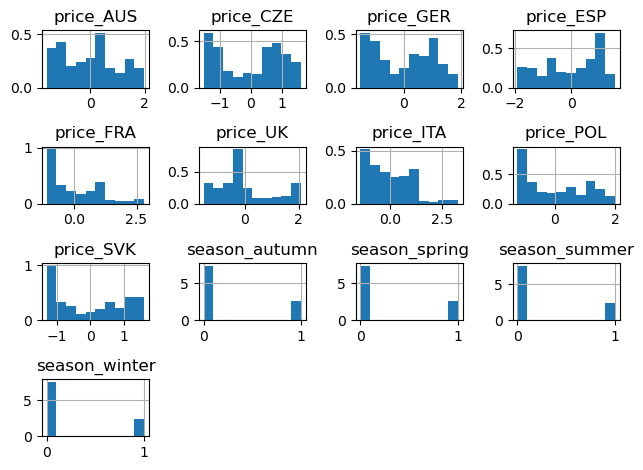

In [ ]:
# Let's now check whether any variable is skewed
X_train_preprocessed.hist(density = True)
plt.tight_layout()

# most of the features are strongly skewed and need to be transformed

## Preprocessing exploration: Feature transformation
The goal here is to transform the features to bell-curve-like-distribution. 

This exploration needs to be done on unscaled features, scaling a feature is always after transforming it.

c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


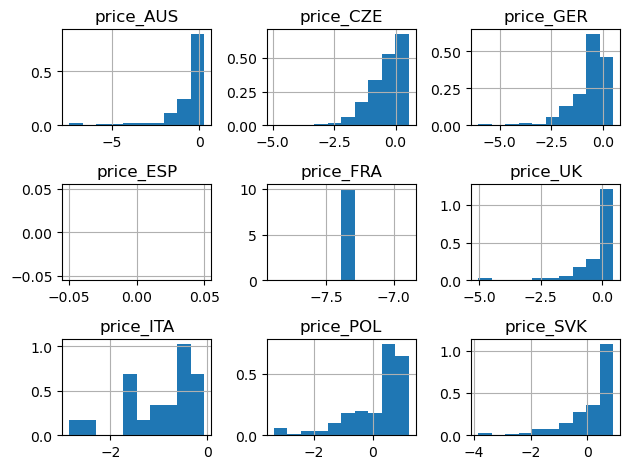

In [ ]:
# log
np.log(X_train_num_imputed).hist(density = True)
plt.tight_layout()

c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\pandas\core\internals\blocks.py:351: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


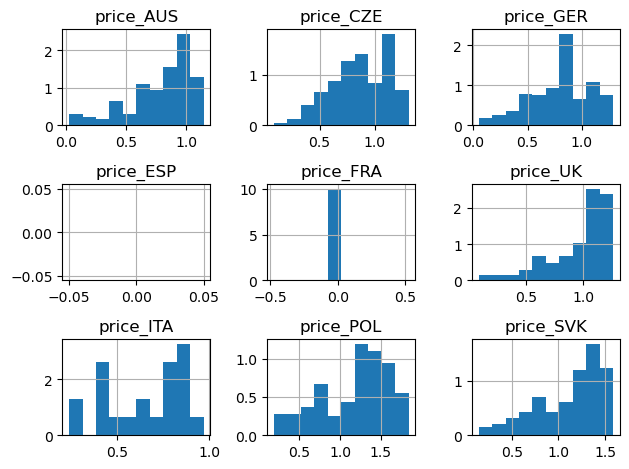

In [ ]:
# root
np.sqrt(X_train_num_imputed).hist(density = True)
plt.tight_layout()

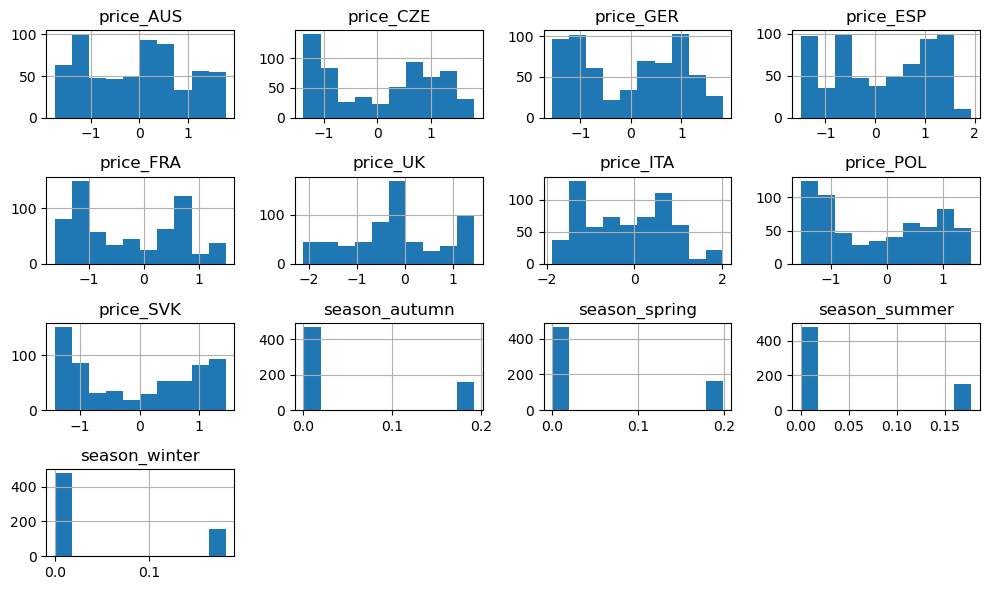

In [ ]:
# yeo johnson
X_train_yeojohnson = pd.DataFrame(index=X_train_preprocessed.index, columns=X_train_preprocessed.columns)
for column in X_train_preprocessed.columns:
    X_train_yeojohnson[column], _ = stats.yeojohnson(X_train_preprocessed[column])

# Plot histograms of transformed data
X_train_yeojohnson.hist(figsize=(10, 6))
plt.tight_layout()

c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\paesc\anaconda3\envs\py311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


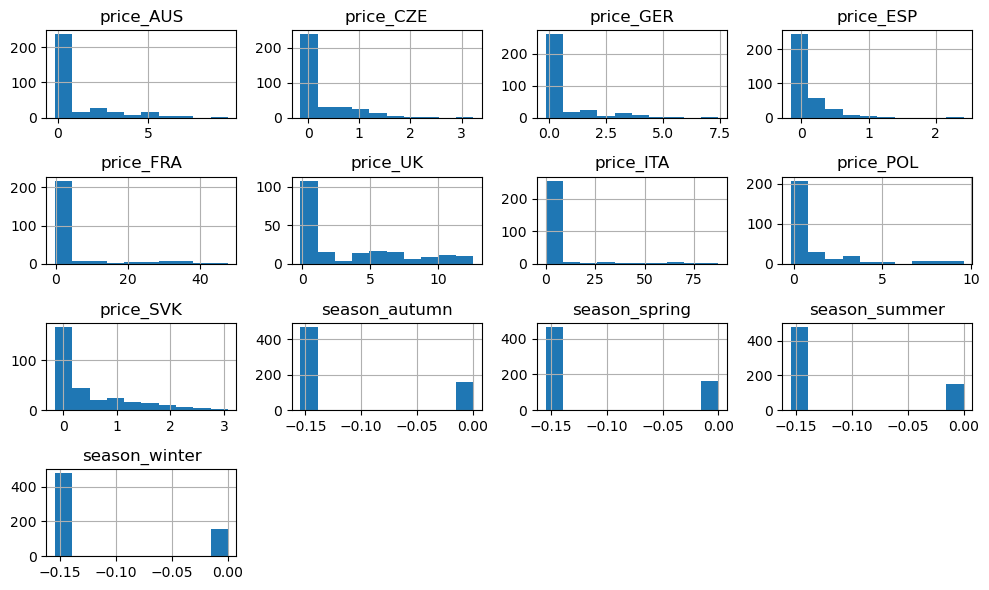

In [ ]:
# log yeo johnson
X_train_yeojohnson = pd.DataFrame(index=X_train_preprocessed.index, columns=X_train_preprocessed.columns)
for column in X_train_preprocessed.columns:
    X_train_yeojohnson[column], _ = stats.yeojohnson(np.log(X_train_preprocessed[column]))

# Plot histograms of transformed data
X_train_yeojohnson.hist(figsize=(10, 6))
plt.tight_layout()